# Introducción a la predicción de series temporales
Las series de tiempo son diferentes de los problemas de modelado predictivo de regresión y clasificación más tradicionales. La estructura temporal agrega un orden a las observaciones. Este orden impuesto significa que los supuestos importantes sobre la coherencia de esas observaciones deben manejarse específicamente.
El objetivo de la predicción de series temporales es realizar predicciones precisas sobre el futuro. En este Jupyter Notebook, nos centraremos en cómo realizar predicciones sobre problemas de series de tiempo univariadas utilizando las herramientas estándar del ecosistema Python. La librería Pandas en Python proporciona un excelente soporte integrado para datos de series de tiempo, mientras que Statsmodels es un módulo de Python que permite a los usuarios explorar datos, estimar modelos estadísticos y realizar pruebas estadísticas.



In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from pandas import Grouper
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings('ignore')

In [6]:
# adjust display settings
%matplotlib inline
plt.rc('figure', figsize=(18, 3))
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_rows = 20

# Carga los Datos

Cargar y explorar los datos


In [11]:
dataframe = pd.read_csv('AirPassengers.csv')
dataframe.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [12]:
dataframe.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


#Crear Serie de Tiempo

Pandas representa conjuntos de datos de series de tiempo como una Serie.
Una Serie es un arreglo unidimensional con una etiqueta de tiempo para cada fila.


In [17]:
dataframe.dtypes
# create a time series

#Convert Month object into datetime
dataframe['Month'] = pd.to_datetime(dataframe.Month)
dataframe = dataframe.set_index(dataframe.Month)
dataframe.drop('Month', axis = 1, inplace = True)
dataframe.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


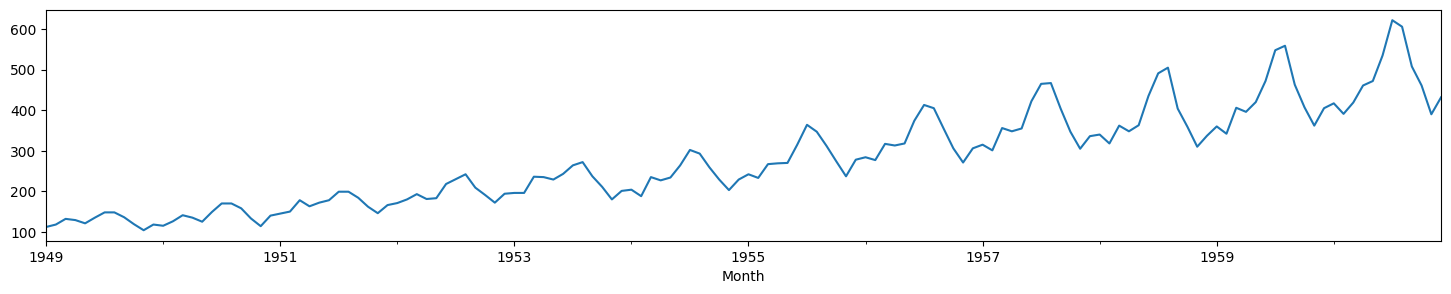

In [22]:
ts = pd.Series(dataframe.unstack().values, index=dataframe.index)
ts.plot();

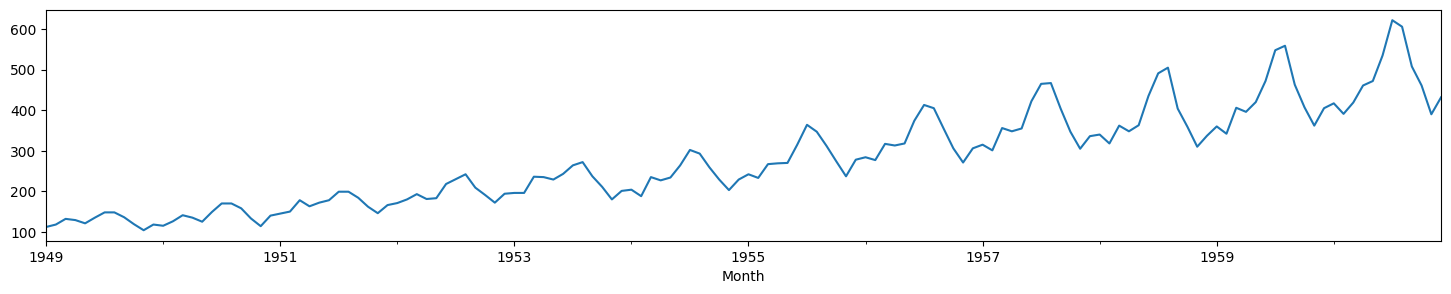

In [23]:
ts = dataframe['#Passengers']
ts.head()
ts.plot();

### Componentes de las Series de Tiempo
Una abstracción útil para seleccionar métodos de pronóstico es descomponer una serie de tiempo en componentes sistemáticos y no sistemáticos.

- **Sistemático**: Componentes de la serie de tiempo que tienen consistencia o recurrencia y pueden ser descritos y modelados.
- **No Sistemático**: Componentes de la serie de tiempo que no pueden ser modelados directamente.

Se considera que una serie de tiempo dada consta de tres componentes sistemáticos que incluyen nivel, tendencia, estacionalidad y un componente no sistemático llamado ruido. Estos componentes se definen de la siguiente manera:

- **Nivel**: El valor promedio en la serie.
- **Tendencia**: El valor creciente o decreciente en la serie.
- **Estacionalidad**: El ciclo corto repetitivo en la serie.
- **Ruido**: La variación aleatoria en la serie.

Nuestro conjunto de datos de series de tiempo puede contener una tendencia. Una tendencia es un aumento o disminución continuo en la serie a lo largo del tiempo. Puede ser beneficioso identificar, modelar e incluso eliminar la información de tendencia de su conjunto de datos de series de tiempo.

Los conjuntos de datos de series de tiempo pueden contener un componente estacional. Este es un ciclo que se repite con el tiempo, como mensual o anual. Este ciclo repetitivo puede ocultar la señal que deseamos modelar al pronosticar y, a su vez, puede proporcionar una señal fuerte a nuestros modelos predictivos. Hay muchos tipos de estacionalidad: hora del día, diaria, semanal, mensual, anual, etc. Determinar si hay un componente de estacionalidad en su problema de series de tiempo es subjetivo. El enfoque más simple para determinar si hay un aspecto de estacionalidad es trazar y revisar sus datos, quizás en diferentes escalas y con la adición de líneas de tendencia.

Una serie de tiempo de la cual se ha eliminado el componente estacional se llama **estacionalmente estacionaria**. Si un conjunto de datos no tiene una tendencia o logramos eliminar la tendencia, se dice que el conjunto de datos es **tendencialmente estacionario**.


#. Estacionariedad de las Series de Tiempo

En una serie de tiempo estacionaria, las observaciones no presentan dependencia temporal.

Se considera que una serie de tiempo es estacionaria cuando no muestra tendencias ni efectos estacionales. Esto se refleja en la constancia de las estadísticas descriptivas a lo largo del tiempo, como **la media** o **la varianza** de las observaciones.
La estacionariedad facilita el modelado de la serie de tiempo, ya que muchos métodos de modelado estadístico presuponen o requieren estacionariedad para ser aplicados de manera efectiva.

#### Verificación de Estacionariedad
Existen numerosos métodos para verificar si una serie de tiempo (observaciones directas, residuos u otros) es estacionaria o no estacionaria.

- **Observar Gráficos**: Puedes revisar un gráfico de la serie de tiempo de tus datos y verificar visualmente si hay tendencias o estacionalidades obvias.
- **Estadísticas Resumidas**: Puedes revisar las estadísticas resumidas de tus datos por temporadas o particiones aleatorias y buscar diferencias obvias o significativas.
- **Pruebas Estadísticas**: Puedes utilizar pruebas estadísticas para verificar si se cumplen las expectativas de estacionariedad o si han sido violadas.


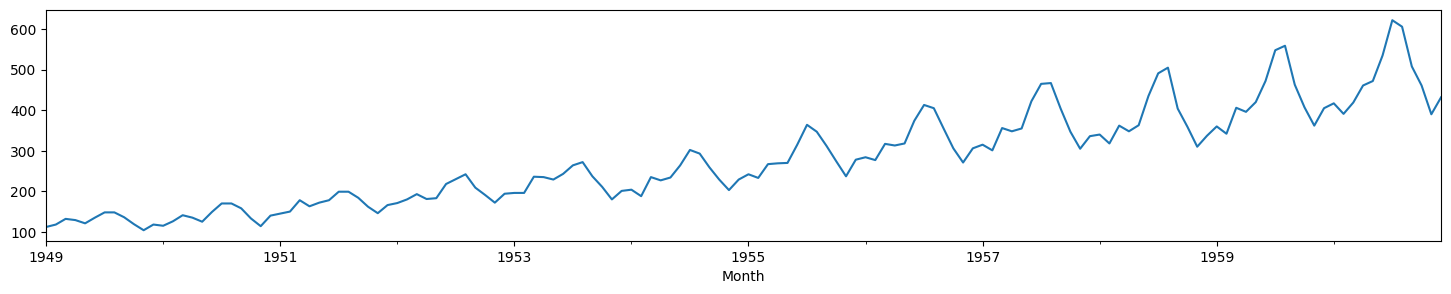

In [24]:
ts.plot();

<Axes: ylabel='Density'>

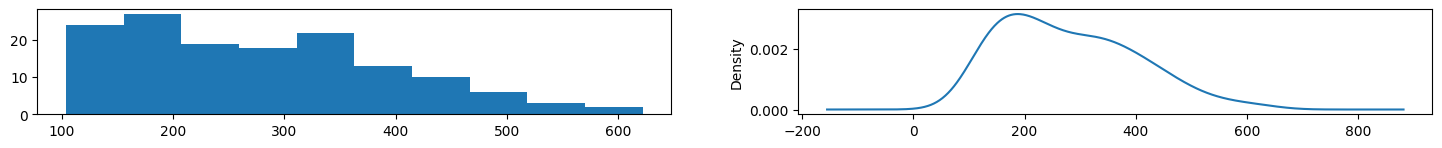

In [25]:
plt.subplot(221)
plt.hist(ts)
plt.subplot(222)
ts.plot(kind = 'kde')

#### Augmented-Dickey-Fuller-test
La prueba de Dickey-Fuller Aumentada es un tipo de test estadístico denominado prueba de raíz unitaria. El principio de una prueba de raíz unitaria radica en determinar el grado de influencia que una tendencia tiene sobre una serie de tiempo. Esta prueba emplea un modelo autorregresivo y perfecciona un criterio de información considerando múltiples valores de retraso (lag). La hipótesis nula plantea que la serie de tiempo se puede caracterizar por una raíz unitaria, sugiriendo que no es estacionaria (presenta una estructura dependiente del tiempo). Por contraste, la hipótesis alternativa, que implica rechazar la hipótesis nula, sostiene que la serie de tiempo es estacionaria.

In [26]:
# calculate stationarity test of time series data
X = ts.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


- **Estadístico ADF (ADF Statistic)**: El valor es de 0.815369. En las pruebas de raíz unitaria como la ADF, valores más negativos son más fuertes para rechazar la hipótesis nula de raíz unitaria (serie de tiempo no estacionaria).
- **Valor p (p-value)**: Un valor p de 0.991880 es significativamente alto y sugiere que no podemos rechazar la hipótesis nula. En general, un valor p por debajo de 0.05 indica fuertes evidencias contra la hipótesis nula.
- **Valores Críticos (Critical Values)**: Estos valores corresponden a los umbrales para los diferentes niveles de significancia. Si el estadístico ADF es menor que estos valores críticos, podemos rechazar la hipótesis nula.

Dado que el estadístico ADF de 0.815369 es mayor que cualquiera de los valores críticos y el valor p es muy alto (mayor que 0.05), no hay suficientes evidencias para rechazar la hipótesis nula. Por lo tanto, en base a esta prueba, no puedes concluir que la serie de tiempo es estacionaria. En otras palabras, los datos podrían tener una raíz unitaria, indicando que la serie de tiempo es no estacionaria y podría tener una estructura dependiente del tiempo.

# Función para test_stationarity

Para simplificar el uso se crea la función par la prueba donde se incluye los graficso estadisticos.  ten en cuenta que he trazado la desviación estándar en lugar de la varianza para mantener la unidad similar a la media.

In [33]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

    #estadísticas móviles
    rolmean = timeseries.rolling(window = 12).mean()
    rolstd = timeseries.rolling(window = 12).std()

    #plotting
    orig = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Media Móvil')
    st = plt.plot(rolstd, color = 'black', label = 'Desviación Estándar Móvil')
    plt.legend(loc = 'best')
    plt.title('Media Móvil y Desviación Estándar Móvil')
    plt.show()

    #Dickey_Fuller test:
    print('Resultados del test  Dickey-Fuller:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)

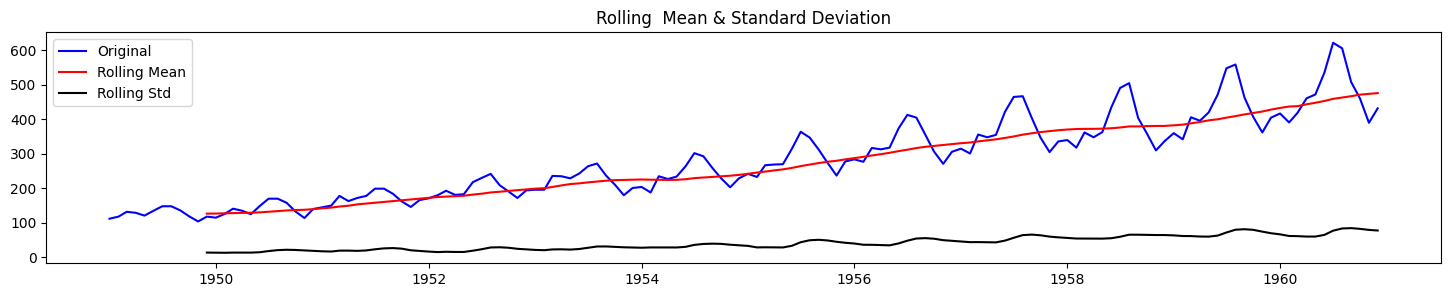

Results of Dickey-Fuller Test:
Test Statistic                  0.82
p-value                         0.99
#Lags Used                     13.00
Number of Observations Used   130.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [28]:
test_stationarity(ts)

La desviación estándar tiene muy poca variación, pero la media está aumentando continuamente. Por lo tanto, no es una serie estacionaria. Además,como ya vimos el estadístico de prueba es mucho mayor que los valores críticos (comparar los valores con signo y no los valores absolutos).

# Que hacer si no hay Estacionariedad
Es casi imposible hacer una serie perfectamente estacionaria, pero tratamos de acercarla lo más posible.

Entendamos qué es lo que hace que una serie de tiempo (TS) no sea estacionaria. Hay 2 razones principales detrás de la no estacionariedad de una TS:
1. Tendencia: media variable a lo largo del tiempo. Por ejemplo, en este caso vimos que, en promedio, el número de pasajeros estaba creciendo con el tiempo.
2. Estacionalidad: variaciones en marcos de tiempo específicos. Por ejemplo, la gente podría tener la tendencia de comprar coches en un mes particular debido a aumentos de sueldo o festivales.

El principio subyacente es modelar o estimar la tendencia y la estacionalidad en la serie y eliminarlas de la serie para obtener una serie estacionaria. Luego se pueden implementar técnicas de pronóstico estadístico en esta serie. El paso final sería convertir los valores pronosticados a la escala original aplicando de nuevo las restricciones de tendencia y estacionalidad.




## Estimación y Eliminación de Tendencia

Podemos ver claramente que existe una tendencia positiva significativa. Por lo tanto, podemos aplicar una transformación que penalice más a los valores altos que a los bajos. Estas pueden ser la toma de logaritmo, raíz cuadrada, raíz cúbica, etc. Tomemos aquí una transformación logarítmica por simplicidad.


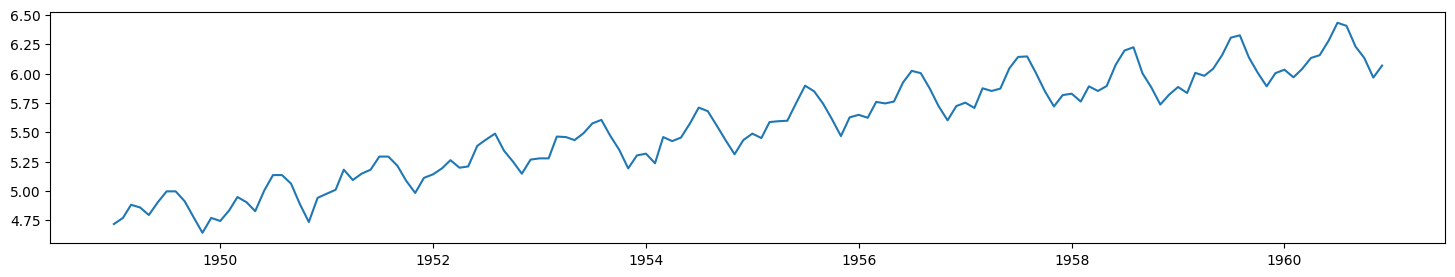

In [31]:
ts_log = np.log(ts)
plt.plot(ts_log)


En este caso más simple, es fácil observar una tendencia ascendente en los datos. Pero no es muy intuitivo en presencia de ruido. Por lo tanto, podemos utilizar algunas técnicas para estimar o modelar esta tendencia y luego eliminarla de la serie. Hay muchas formas de hacerlo y algunas de las más comúnmente utilizadas son:

- Agregación: tomar el promedio de un período de tiempo, como promedios mensuales o semanales.

- Suavizado: tomar promedios móviles.

- Ajuste Polinómico: ajustar un modelo de regresión.

Aquí aplicaremos suavizado.




## Media movil
En este enfoque, tomamos el promedio de 'k' valores consecutivos dependiendo de la frecuencia de la serie de tiempo. Aquí podemos tomar el promedio de los útimos 12 valores, es decir, el último año. Pandas tiene funciones específicas definidas para determinar estadísticas móviles.


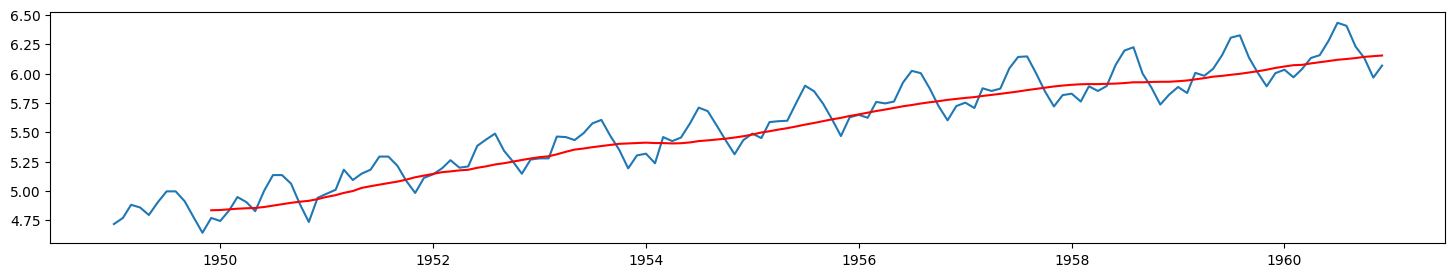

In [36]:
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color = 'red')



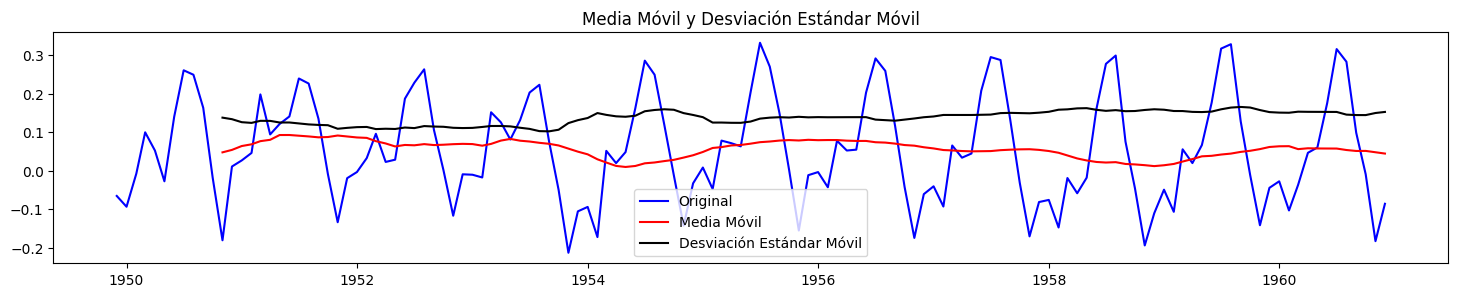

Resultados del test  Dickey-Fuller:
Test Statistic                 -3.16
p-value                         0.02
#Lags Used                     13.00
Number of Observations Used   119.00
Critical Value (1%)            -3.49
Critical Value (5%)            -2.89
Critical Value (10%)           -2.58
dtype: float64


In [37]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace = True)
test_stationarity(ts_log_moving_avg_diff)

Los valores móviles parecen variar ligeramente, pero no hay una tendencia específica. Además, el estadístico de prueba es menor que los valores críticos del 5%, por lo que podemos decir con un 95% de confianza que esta es una serie estacionaria. Sin embargo, una desventaja de este enfoque particular es que el período de tiempo tiene que estar estrictamente definido. En este caso podemos tomar promedios anuales, pero en situaciones más complejas, como la previsión del precio de una acción, es difícil llegar a un número. Por lo tanto, tomamos una 'media móvil ponderada' donde se da un mayor peso a los valores más recientes. Una opción popular es la media móvil ponderada exponencialmente, donde se asignan pesos a todos los valores anteriores con un factor de decaimiento.

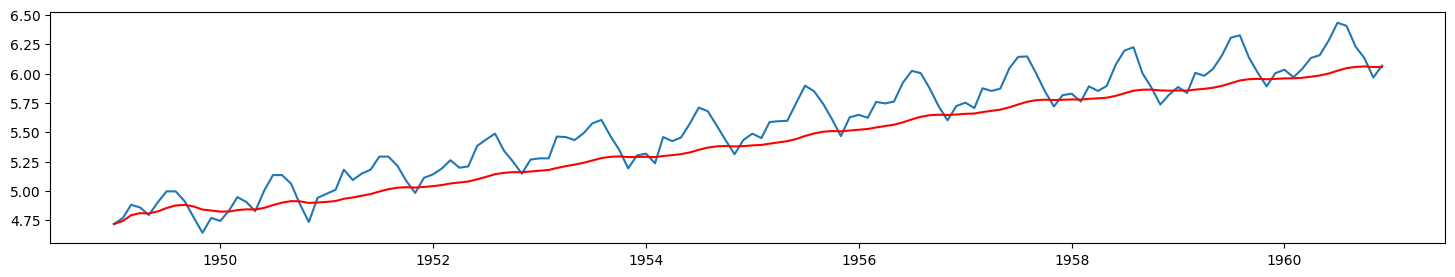

In [38]:
exp_weighted_avg = ts_log.ewm(halflife = 12).mean()
plt.plot(ts_log)
plt.plot(exp_weighted_avg, color = 'red')

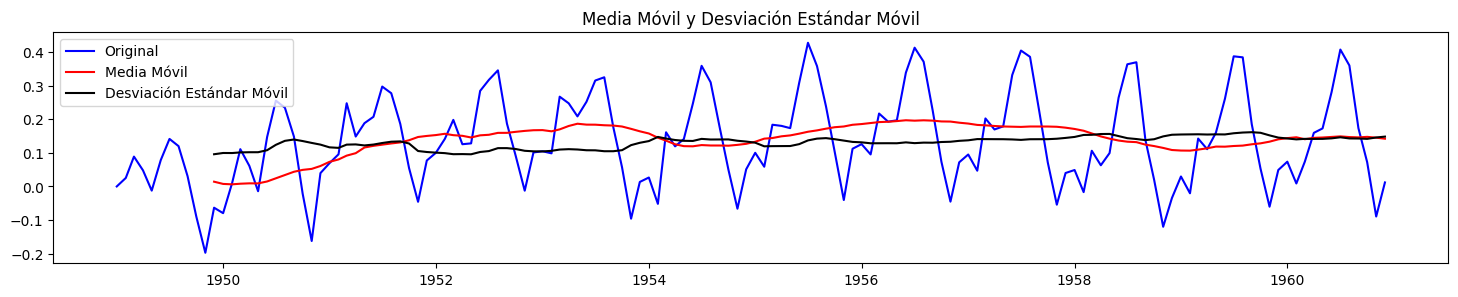

Resultados del test  Dickey-Fuller:
Test Statistic                 -3.60
p-value                         0.01
#Lags Used                     13.00
Number of Observations Used   130.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [39]:
ts_log_ema_diff = ts_log - exp_weighted_avg
test_stationarity(ts_log_ema_diff)

Esta serie de tiempo presenta aún menores variaciones en la media y en la desviación estándar en magnitud. Además, el estadístico de prueba es menor que el valor crítico del 1%, lo que es mejor que en el caso anterior.

## Eliminando Tendencia y Estacionalidad

Dos métodos:
 1. Diferenciación (tomando la diferencia con un cierto retraso temporal)
 2. Descomposición (modelando tanto la tendencia como la estacionalidad y eliminándolas del modelo)


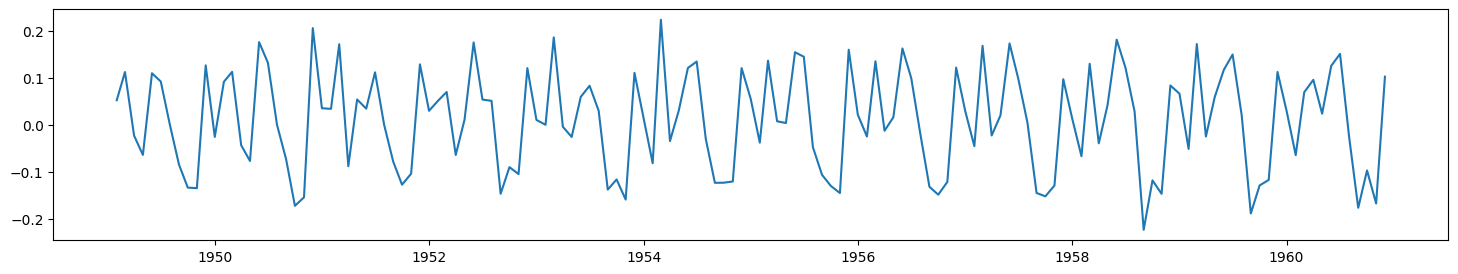

In [40]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

### Diferenciación

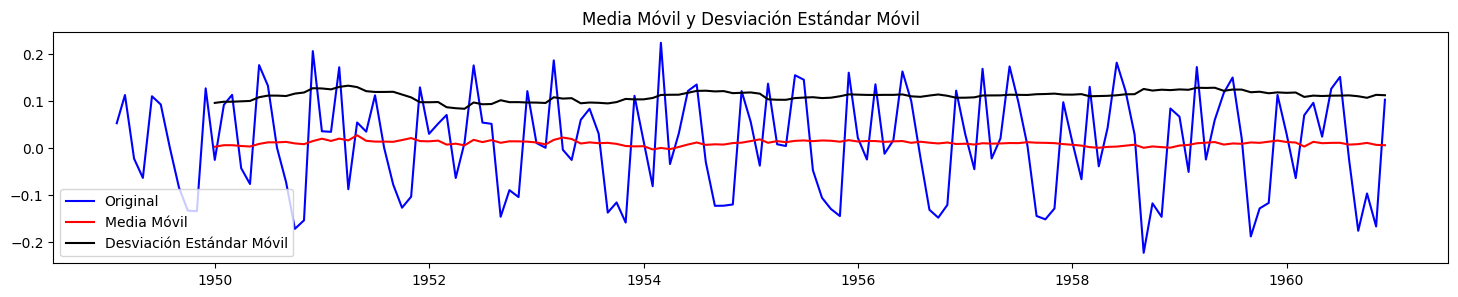

Resultados del test  Dickey-Fuller:
Test Statistic                 -2.72
p-value                         0.07
#Lags Used                     14.00
Number of Observations Used   128.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [42]:
ts_log_diff.dropna(inplace = True)
test_stationarity(ts_log_diff)

Podemos ver que las variaciones de la media y la desviación estándar tienen pequeñas variaciones con el tiempo. Además, el estadístico de prueba de Dickey-Fuller es menor que el valor crítico del 10%, por lo tanto, la serie de tiempo es estacionaria con un 95% de confianza. También podemos tomar diferencias de segundo o tercer orden, lo que podría obtener aún mejores resultados en ciertas aplicaciones.

### Descomposición

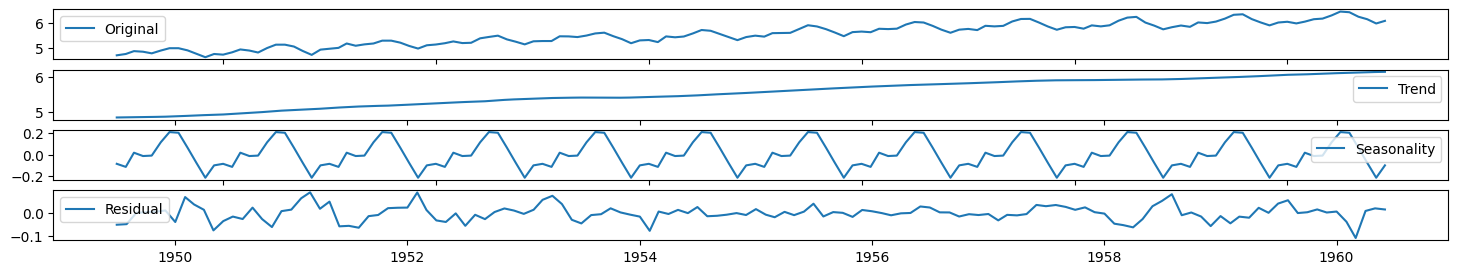

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residual')
plt.legend(loc = 'best')

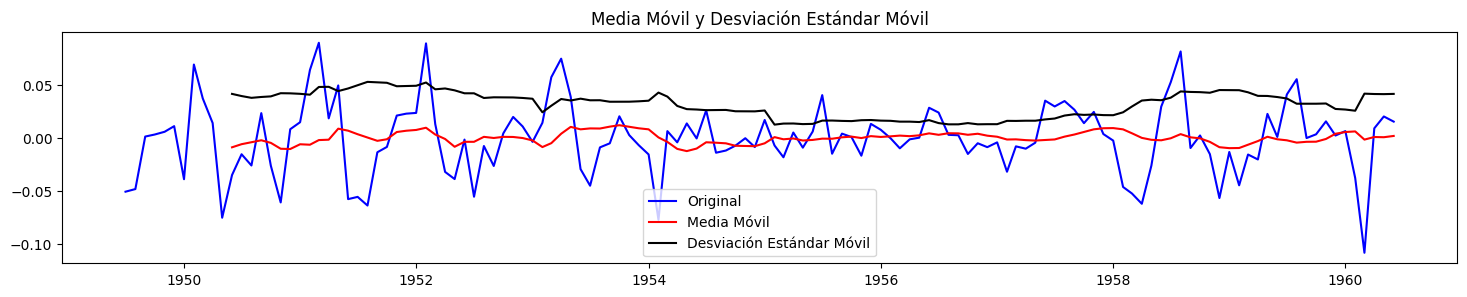

Resultados del test  Dickey-Fuller:
Test Statistic                 -6.33
p-value                         0.00
#Lags Used                      9.00
Number of Observations Used   122.00
Critical Value (1%)            -3.49
Critical Value (5%)            -2.89
Critical Value (10%)           -2.58
dtype: float64


In [44]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace = True)
test_stationarity(ts_log_decompose)

El estadístico de prueba de Dickey-Fuller es significativamente más bajo que el valor crítico del 1%. Por lo tanto, esta serie de tiempo está muy cerca de ser estacionaria

# Pronóstico de una Serie de Tiempo

Habiendo realizado las técnicas de estimación de tendencia y estacionalidad, puede haber dos situaciones:

1. Una serie estrictamente estacionaria sin dependencia entre los valores. Este es el caso fácil en el que podemos modelar los residuos como ruido blanco. Pero esto es muy raro.
2. Una serie con dependencia significativa entre valores. En este caso, necesitamos utilizar algunos modelos estadísticos como **ARIMA** para pronosticar los datos.

El pronóstico **ARIMA** para una serie de tiempo estacionaria no es más que una ecuación lineal (como una regresión lineal). Los predictores dependen de los parámetros (p, d, q) del modelo **ARIMA**:

1. Número de términos **AR (Auto-Regresivos) (p)**: Los términos AR son simplemente retrasos de la variable dependiente. Por ejemplo, si p es 5, los predictores para x(t) serán x(t-1)…x(t-5).

2. Número de términos **MA (Media Móvil) (q)**: Los términos MA son errores de pronóstico rezagados en la ecuación de predicción. Por ejemplo, si q es 5, los predictores para x(t) serán e(t-1)…e(t-5) donde e(i) es la diferencia entre la media móvil en el instante i y el valor real.

3. Número de Diferencias **(d)**: Estos son el número de diferencias no estacionales, es decir, en este caso tomamos la primera diferencia. Así que podemos pasar esa variable y poner d=0 o pasar la variable original y poner d=1. Ambos generarán los mismos resultados.

Una preocupación importante aquí es cómo determinar el valor de 'p' y 'q'. Usamos dos gráficos para determinar estos números.

1. **Función de Autocorrelación (ACF)**: Es una medida de la correlación entre la Serie de Tiempo con una versión rezagada de sí misma. Por ejemplo, en el retraso 5, ACF compararía la serie en el instante de tiempo 't1'...'t2' con la serie en el instante 't1-5'...'t2-5' (siendo t1-5 y t2 los puntos finales).

2. **Función de Autocorrelación Parcial (PACF)**: Mide la correlación entre la Serie de Tiempo con una versión rezagada de sí misma pero después de eliminar las variaciones ya explicadas por las comparaciones intermedias. Por ejemplo, en el retraso 5, verificará la correlación pero eliminará los efectos ya explicados por los retrasos 1 a 4.


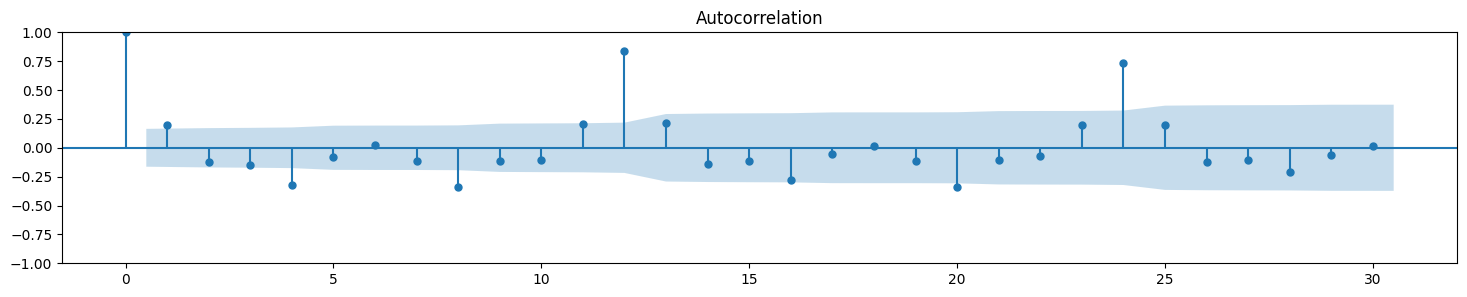

In [56]:
plot_acf(ts_log_diff, lags=30)
plt.show()

Debido a la estacionalidad, en el retraso 12 la autocorrelación es alta y para cada múltiplo de 12, la autocorrelación será alta pero seguirá disminuyendo a medida que nos alejamos.



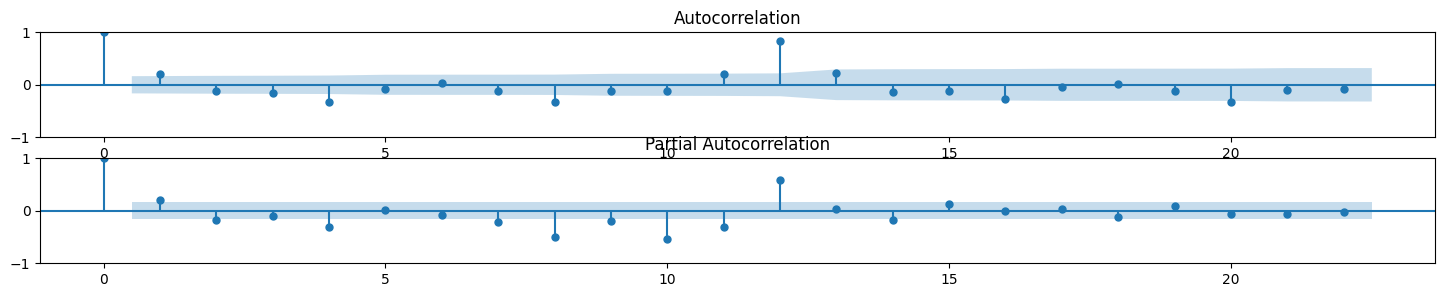

In [50]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.subplot(211)
plot_acf(ts_log_diff, ax=plt.gca())
plt.subplot(212)
plot_pacf(ts_log_diff, ax=plt.gca())
plt.show()

In [51]:
#Another method
#ACF and PACF plots
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

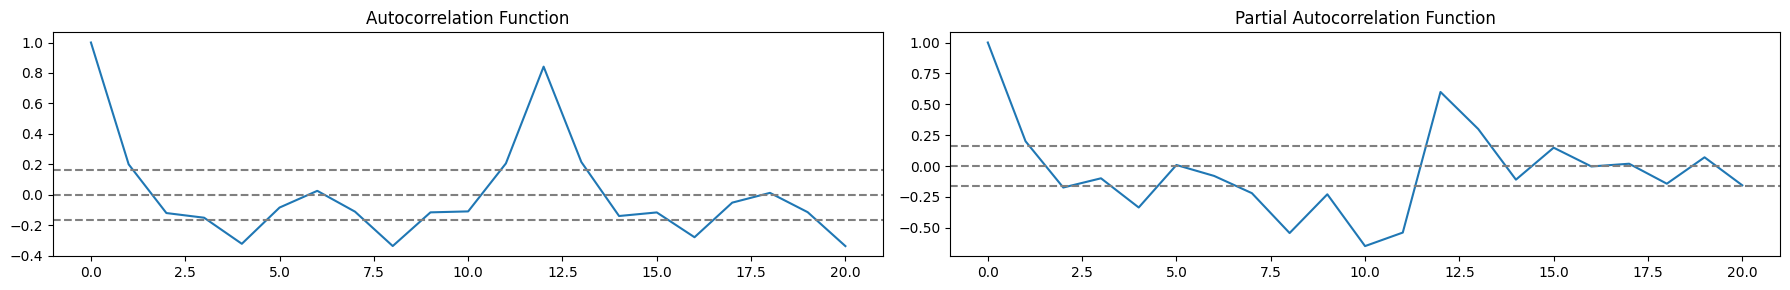

In [52]:
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y = 0, linestyle = '--', color = 'gray') #Add a horizontal line across the axis at y = 0.
plt.axhline(y = -1.96/np.sqrt(len(ts_log_diff)), linestyle = '--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(ts_log_diff)), linestyle = '--', color = 'gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y = -1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color = 'gray')
plt.axhline(y = 1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color = 'gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

En este gráfico, las dos líneas punteadas a ambos lados de 0 son los intervalos de confianza. Estos pueden ser utilizados para determinar los valores de 'p' y 'q' como:

p - El valor de retraso donde el gráfico PACF cruza el intervalo de confianza superior por primera vez (p=2).

q - El valor de retraso donde el gráfico ACF cruza el intervalo de confianza superior por primera vez (q=2).

Ahora, hagamos 3 modelos ARIMA diferentes considerando efectos individuales así como combinados. También imprimiremos el RSS para cada uno. Por favor, tenga en cuenta que aquí el RSS es para los valores de los residuos y no para la serie real.

In [59]:
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMA


## Modelo Auto-Regresivo
La autoregresión es un modelo de series de tiempo que utiliza observaciones de pasos de tiempo anteriores como entrada a una ecuación de regresión para predecir el valor en el siguiente paso de tiempo. Es una idea muy simple que puede resultar en pronósticos precisos en una variedad de problemas de series de tiempo.

Un modelo de autoregresión asume que las observaciones en los pasos de tiempo actuales y anteriores son útiles para predecir el valor en el siguiente paso de tiempo. Esta relación entre variables se llama correlación. Si ambas variables cambian en la misma dirección, esto se llama correlación positiva. Si las variables se mueven en direcciones opuestas a medida que cambian los valores (por ejemplo, una sube y otra baja), entonces esto se llama correlación negativa.


Text(0.5, 1.0, 'RSS: nan')

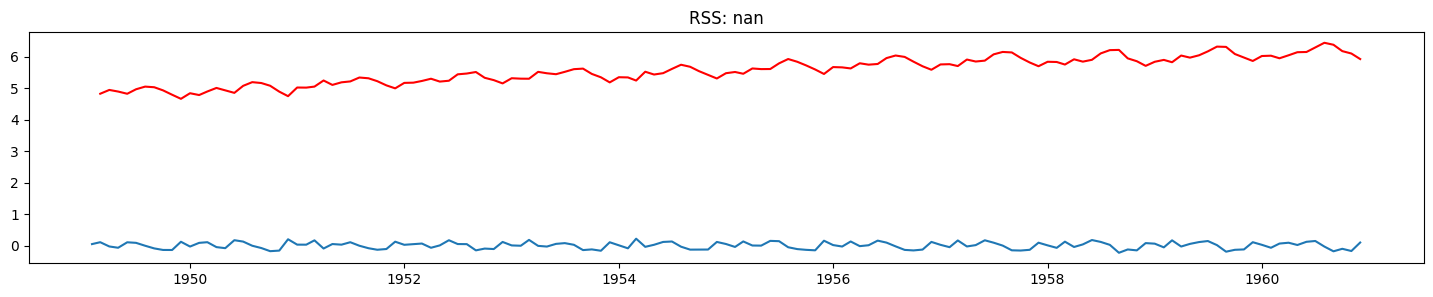

In [63]:
from statsmodels.tsa.ar_model import AutoReg
model = AutoReg(ts_log, lags=2)

results_AR = model.fit()
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color = 'red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues - ts_log_diff)**2)) #Residual sum of squares

## Modelo Moving-Average

La diferencia entre lo que se esperaba y lo que se predijo se llama error residual. Los errores residuales de los pronósticos en una serie de tiempo proporcionan otra fuente de información que podemos modelar. Los errores residuales en sí mismos forman una serie de tiempo que puede tener estructura temporal. Un modelo simple de autoregresión de esta estructura se puede utilizar para predecir el error de pronóstico, que a su vez se puede utilizar para corregir pronósticos. Este tipo de modelo se llama modelo de media móvil, el mismo nombre pero muy diferente del suavizado de media móvil.

Text(0.5, 1.0, 'RSS: nan')

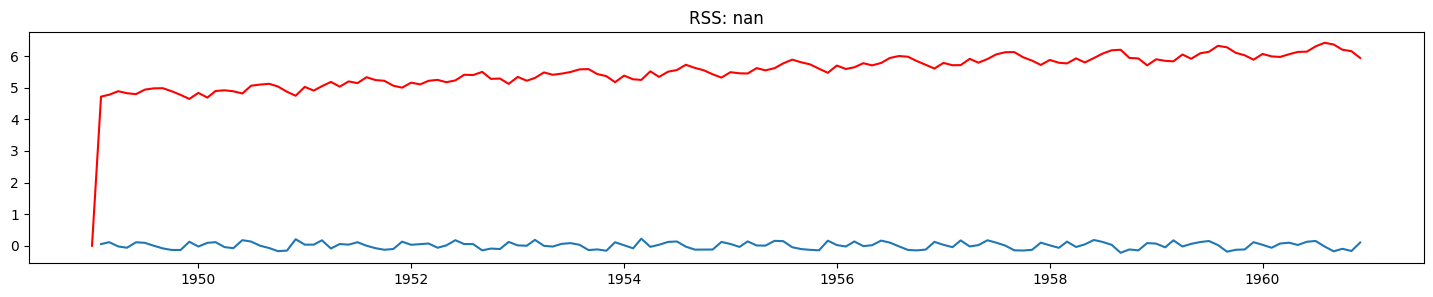

In [65]:
model = ARIMA(ts_log, order= (0, 1, 2))
results_MA = model.fit()
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color= 'red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues - ts_log_diff)**2))

### Modelo ARIMA para Pronósticos

El Modelo Autoregresivo Integrado de Media Móvil, o ARIMA por sus siglas en inglés, es un modelo estadístico estándar para el pronóstico y análisis de series de tiempo. Un modelo ARIMA es una clase de modelo estadístico para analizar y pronosticar datos de series de tiempo.
ARIMA es un acrónimo que significa **Modelo Autoregresivo Integrado de Media Móvil**. Este acrónimo es descriptivo, capturando los aspectos clave del modelo en sí:
<ul>
<li><strong>AR</strong>: Autoregresión. Un modelo que utiliza la relación dependiente entre una observación y un cierto número de observaciones rezagadas.</li>
<li><strong>I</strong>: Integrado. El uso de la diferenciación de observaciones crudas (es decir, restar una observación de una observación en el paso de tiempo anterior) para hacer la serie de tiempo estacionaria.</li>
<li><strong>MA</strong>: Media Móvil. Un modelo que utiliza la dependencia entre una observación y los errores residuales de un modelo de media móvil aplicado a observaciones rezagadas.</li>
</ul>
Los parámetros del modelo ARIMA se definen de la siguiente manera:
<ul>
<li><strong><em>p</em></strong>: El número de observaciones rezagadas incluidas en el modelo, también llamado el orden de retraso.</li>
<li><strong><em>d</em></strong>: El número de veces que las observaciones crudas son diferenciadas, también llamado el grado de diferenciación.</li>
<li><strong><em>q</em></strong>: El tamaño de la ventana de media móvil, también llamado el orden de media móvil.</li>
</ul>


Comencemos con algo sencillo. Ajustaremos un modelo ARIMA al conjunto completo de datos y revisaremos los errores residuales. Primero, ajustamos un modelo ARIMA(5,1,0). Esto establece el valor de retraso en 5 para la autoregresión, utiliza un orden de diferenciación de 1 para hacer la serie de tiempo estacionaria y utiliza un modelo de media móvil de 0.


In [67]:
# fit model
model = ARIMA(ts, order=(5,1,0))
model_fit = model.fit()

In [68]:
# summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -689.067
Date:                Tue, 31 Oct 2023   AIC                           1390.135
Time:                        17:28:36   BIC                           1407.912
Sample:                    01-01-1949   HQIC                          1397.358
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3223      0.097      3.334      0.001       0.133       0.512
ar.L2         -0.2170      0.078     -2.776      0.006      -0.370      -0.064
ar.L3         -0.0646      0.071     -0.915      0.3

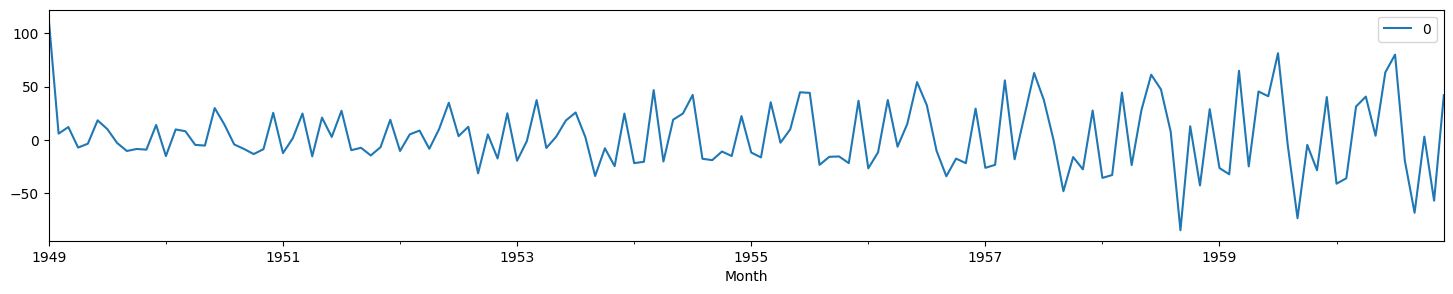

In [69]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

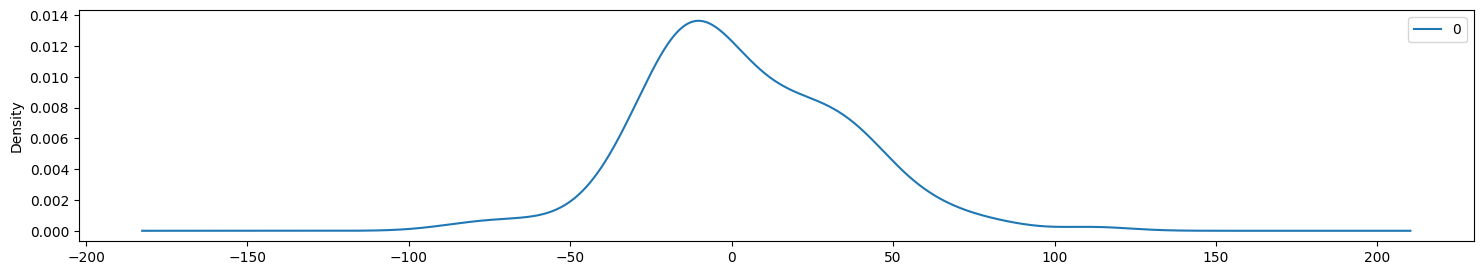

In [70]:
# density plot of residuals
residuals.plot(kind='kde');

[(-2.0, 2.0)]

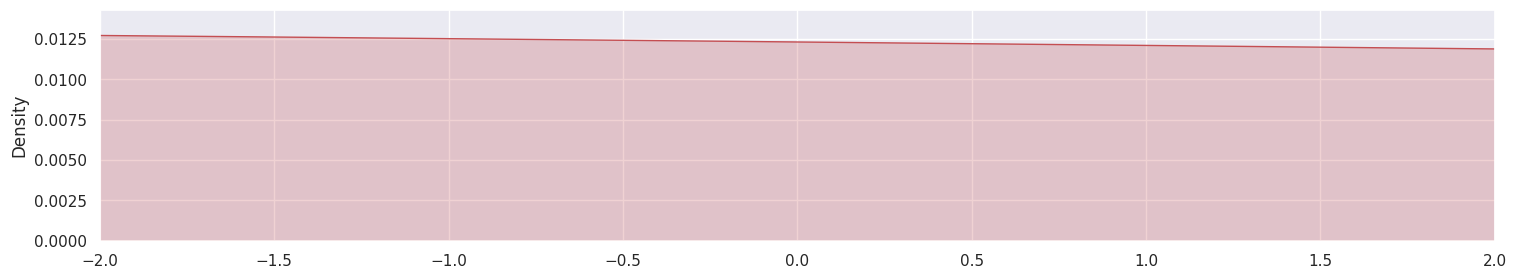

In [71]:
# density plot of residuals, using Seaborn kdeplot
sns.set(color_codes=True)
sns.kdeplot(np.hstack(residuals.values), shade=True, color="r").set(xlim=(-2, 2))

In [72]:
# summary stats of residuals
residuals.describe()

,0
count,144.00
mean,3.89
std,31.09
min,-84.40
25%,-16.55
50%,-1.79
75%,25.07
max,112.00


# Ejercicio 1

Podemos dividir el conjunto de datos de entrenamiento en conjuntos de entrenamiento y prueba, usar el conjunto de entrenamiento para ajustar el modelo y generar una predicción para cada elemento en el conjunto de prueba.?

Podemos calcular una puntuación final del error cuadrático medio de la raíz (RMSE) para las predicciones, proporcionando un punto de comparación para otras configuraciones de ARIMA.?



# Ejercicio 2
Descargue el conjunto de datos de Tasas de fondos federales efectivas del [sitio web de datos económicos de FRED](https://fred.stlouisfed.org/series/FEDFUNDS). La tasa de fondos federales es la tasa de interés a la que las instituciones de depósito intercambian fondos federales entre sí durante la noche. Nos centraremos en pronosticar los tipos de interés hasta la crisis financiera de 2008.

Para la serie temporal:

1. Evalue la estacionariedad
2. Elimine posibles tendencies
3. Realice una división train-test
3. Realice un modelo autoregresivo (`AR`) con el train set.
5. Desarrolle un modelo ARIMA sobre el train set y evalúe el desempeño sobre el test set.
